In [4]:
%matplotlib inline
from scipy.stats import linregress
import os
import numpy as np
from matplotlib import pyplot as plt
from sequence_lib import rc_seq
from biofile import simple_fasta_load
import pandas as pd
# add white background in the cell
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
os.chdir('/home/zhuwei/data/development/collection/data/190214_deletion_primer')

In [6]:
# Load genome sequence

chroms, seqs = simple_fasta_load('./data/bg2.05.fa')
bg2_genome = {c: s for c, s in zip(chroms, seqs)}

Visualize the distribution of unqiue 10-kmers


In [10]:


def generate_unique_kmer(fasta: str, ksize: int):
    '''
    Generate locations for unqiue kmer locations in the strain
    :param fasta: name of the fasta file
    :param prefix: prefix of the output file
    :param ksize: size for unique kmer
    :return: None
    '''
    # first filter for unqiue kmers
    _, seqs = simple_fasta_load(fasta)
    seqs = map(lambda x: x.upper(), seqs)
    kmer_count = {}
    # perform kmer counting from W and C strand to
    # filter for kmer unique in both strand
    # palindromic kmer saved as single copy
    # non-palindromic kmer in both directions were saved.
    for s in seqs:
        for i in range(len(s) - ksize + 1):
            kmer = s[i: i + ksize]
            kmer_count.setdefault(kmer, 0)
            kmer_count[kmer] += 1
        rs = rc_seq(s)
        for i in range(len(s) - ksize + 1):
            kmer = rs[i: i + ksize]
            kmer_count.setdefault(kmer, 0)
            kmer_count[kmer] += 1
    unique_kmer = []
    for kmer, count in kmer_count.items():
        if count == 2:
            if kmer == rc_seq(kmer):
                unique_kmer.append(kmer)
        elif count == 1:
            unique_kmer.append(kmer)
    return unique_kmer


In [12]:
# Get the unqiue kmers
bg2_unque_10mer = generate_unique_kmer('./data/bg2.05.fa', ksize=10)
print('%d unique 10 mers in BG2' % len(bg2_unque_10mer))

20644 unique 10 mers in BG2


In [11]:
# Search the locations of unique kmers
unqiue_loc = {}
ksize = 10
for c, s in bg2_genome.items():
    s = s.upper()
    kdict = {}
    for i in range(len(s) - ksize + 1):
        kmer = s[i: i + ksize]
        kdict[kmer] = i
    unqiue_loc[c] = np.array([kdict[k] for k in bg2_unque_10mer if k in kdict])
    unqiue_loc[c].sort()


NameError: name 'bg2_unque_10mer' is not defined

In [49]:
# calc distances between unqiue kmer
unique_10mer_gap = np.array([])
for loc in unqiue_loc.values():
    unique_10mer_gap = np.concatenate([unique_10mer_gap, np.diff(loc)])


/home/zhuwei/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


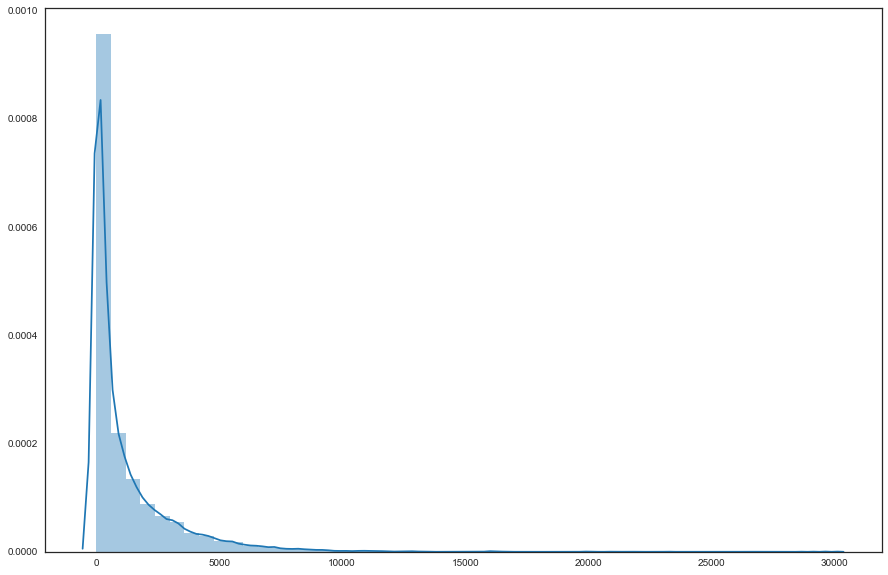

In [50]:
sns.distplot(unqiue_10mer_gap)

/home/zhuwei/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


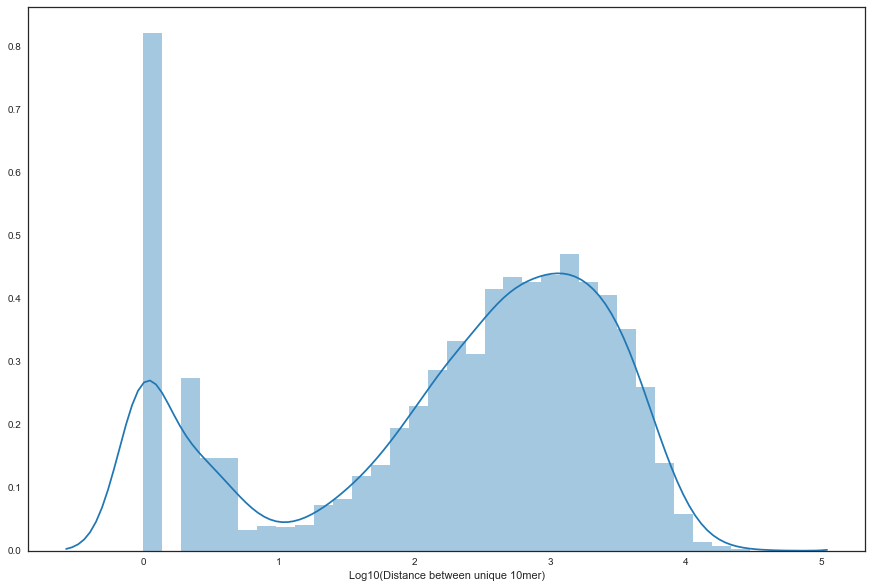

In [51]:
sns.distplot(np.log10(unqiue_10mer_gap), axlabel='Log10(Distance between unique 10mer)')

In [53]:
# Plot the location and gap distance
unique_10mer_chrom_loc = np.array([])
for c, loc in unqiue_loc.items():
    loc = loc / len(bg2_genome[c])
    unique_10mer_chrom_loc = np.concatenate([unique_10mer_chrom_loc, loc[:-1]])


Text(0.5, 0, 'Relative location')

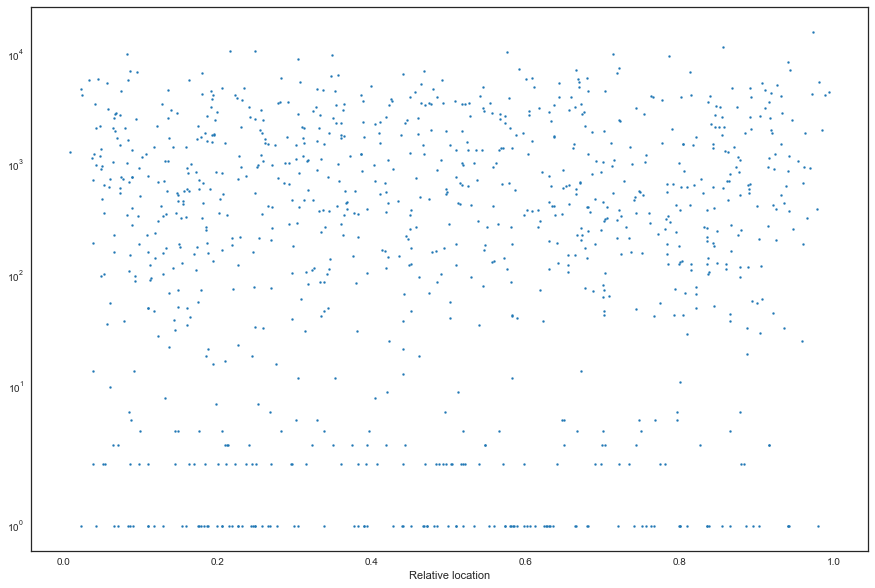

In [54]:
# plot 10% data

sample_id = np.random.randint(0, 10, size=len(unique_10mer_chrom_loc))
sample_gap = unqiue_10mer_gap[sample_id == 1]
sample_distance = unique_10mer_chrom_loc[sample_id == 1]
plt.scatter(sample_distance, sample_gap, s=4)
plt.yscale('symlog')
plt.xlabel('Relative location')

# Generate regions that could be uniquely PCR amplified
unique PCR regions: 300-500 bp
first and last 10 mer of the region satisfy:
  1. both are unqiue
  2. other off target product had size >= 1 kb
Data preprocessing:
  omit kmer has > 5 occurances in the genome

In [14]:
# Generate the kmer location table by chromosome
# Chromosome converted to 0-12 for A-M
ksize = 10
max_total_hit= 10
    z   

In [42]:
# Look for unqiue PCR locations
# For each forward kmer, look for kmer from 500->300
# and check the uniqueness condition.
# If the kmer pair passed the condition, make a step for 100 bp
# Otherwise check next forward kmer
# skip if the next kmer had the same number of target site with the current one

unqiue_pcr_loc = {}

step_success = 100
max_pcr = 500
min_pcr = 300
pcr_th = 1000

def cstrand_location(p, size):
    return size - 1 - p

def is_unqiue_pair(chid, floc, rloc, max_size, is_reverse=False):   
    is_unique = True
    for i in range(13):
        tmp_floc = floc[floc[:, 0] == i]
        tmp_rloc = rloc[rloc[:, 0] == i]
        if not (len(tmp_floc) > 0 and len(tmp_rloc) > 0):
            continue
        tmp_floc = tmp_floc[:, 1]
        tmp_rloc = tmp_rloc[:, 1]
        fsize = tmp_floc.shape[0]
        rsize = tmp_rloc.shape[0]
        tmp_floc = tmp_floc.reshape(fsize, 1)
        tmp_rloc = tmp_rloc.reshape(1, rsize)
        tmp_floc = np.repeat(tmp_floc, rsize, axis=1)
        tmp_rloc = np.repeat(tmp_rloc, fsize, axis=0)
        dist = tmp_rloc - tmp_floc
        if not is_reverse and chid == i:
            if np.sum((dist > 0) & (dist < max_size)) > 1:
                is_unique = False
                break
        else:
            if np.sum((dist > 0) & (dist < max_size)) > 0:
                is_unique = False
                break            
    return is_unique


for c, s in bg2_genome.items():
    s = s.upper()
    rs = rc_seq(s)
    csize = len(s)
    chid = ord(c[-1]) - 65
    pos = 0
    while pos < csize - max_pcr:
        kmer = s[pos: pos + ksize]
        if kmer not in f_kmer_location:
            pos += 1
            continue
        is_unique_pcr = False
        floc = f_kmer_location[kmer]
        if kmer in r_kmer_location:
            rfloc = r_kmer_location[kmer]
        else:
            rfloc = None
        cur_f = [chid, pos]
        # search reverse kmer
        cpos = cstrand_location(pos, csize)
        if cpos < max_pcr:
            continue
        csearch_left = cpos - max_pcr
        csearch_right = cpos - min_pcr
        for p in range(csearch_right, csearch_left - 1, -ksize // 2):
            rkmer = rs[p: p + ksize]
            if rkmer not in r_kmer_location:
                continue
            rloc = r_kmer_location[rkmer]
            cur_r = [chid, cstrand_location(p, csize)]
            # Check unique condition
            is_unique = is_unqiue_pair(chid, floc, rloc, pcr_th)
            # Pass the test
            if is_unique:
                # check reverse direction
                if rfloc is not None:
                    if rkmer in f_kmer_location:
                        rrloc = f_kmer_location[rkmer]
                        is_unique_r = is_unqiue_pair(chid, rrloc, rfloc, pcr_th, is_reverse=True)
                        if is_unique_r:
                            is_unique_pcr = True
                            break
                        else:
                            continue
                is_unique_pcr = True
                break
        if is_unique_pcr:
            unqiue_pcr_loc.setdefault(c, [])
            unqiue_pcr_loc[c].append([pos, cur_r[1]])
            pos += step_success
        else:
            pos += 1
            
    print('{0} Unqiue PCR regions identified in {1}'.format(
          len(unqiue_pcr_loc[c]), c))


4354 Unqiue PCR regions identified in ChrA


4507 Unqiue PCR regions identified in ChrB


4784 Unqiue PCR regions identified in ChrC


6153 Unqiue PCR regions identified in ChrD


6050 Unqiue PCR regions identified in ChrE


8311 Unqiue PCR regions identified in ChrF


8812 Unqiue PCR regions identified in ChrG


9241 Unqiue PCR regions identified in ChrH


5997 Unqiue PCR regions identified in ChrI


10641 Unqiue PCR regions identified in ChrJ


11679 Unqiue PCR regions identified in ChrK


16112 Unqiue PCR regions identified in ChrL


12652 Unqiue PCR regions identified in ChrM


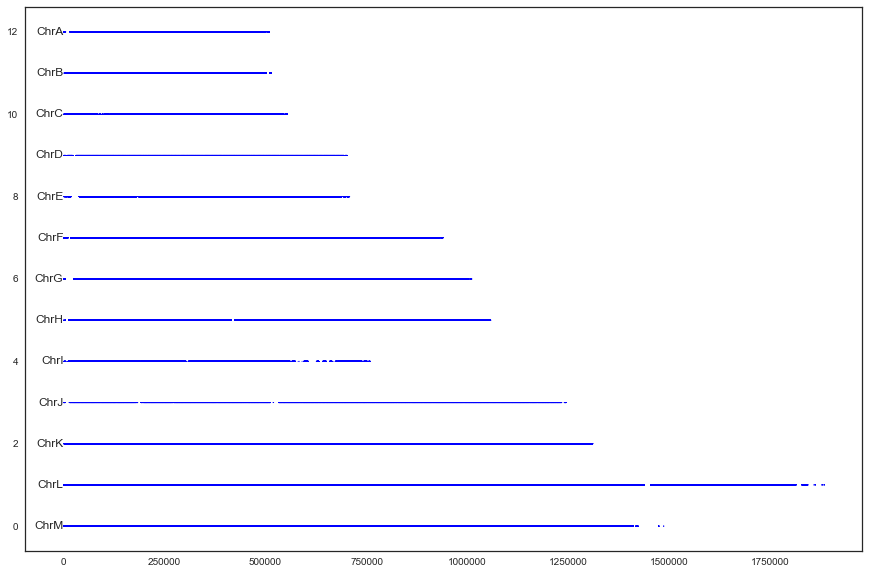

In [44]:
# Draw PCR unqiue regions
plot_x = []
plot_y = []
for c, loc in unqiue_pcr_loc.items():
    chid = ord(c[-1]) - 65
    chid = 12 - chid
    plot_y.extend([chid, chid, None] * len(loc))
    for l in loc:
        plot_x.extend([l[0], l[1], None])
plt.plot(plot_x, plot_y, color='blue', lw=1)
for i in range(13):
    chrom = 'Chr' + chr(65 + i)
    plt.text(0, 12 - i, chrom, ha='right', va='center')


In [45]:
# save unique pcr location
with open('bg2.05.pcr.unique.location.tab', 'w') as filep:
    chroms = sorted(unqiue_pcr_loc.keys())
    content = []
    for c in chroms:
        for l in unqiue_pcr_loc[c]:
            content.append('{0}\t{1}\t{2}\n'.format(c, l[0], l[1]))
    filep.write(''.join(content))


In [49]:
# generate regions with no unique pcr
non_pcr_loc = {}
min_non_pcr_dist = 100
for c, loc in unqiue_pcr_loc.items():
    cur_l = loc[0]
    size = 0
    non_pcr_loc.setdefault(c, [])    
    for l in loc[1:]:
        if cur_l[1] + min_non_pcr_dist < l[0]:
            non_pcr_loc[c].append([cur_l[1] + 1, l[0] - 1])
            size += l[0] - cur_l[1] - 3
        cur_l = l
            
    print('{} non-unique PCR region in {}, with total size of {}'.format(
        len(non_pcr_loc[c]), c, size))
    

9 non-unique PCR region in ChrA, with total size of 18857
3 non-unique PCR region in ChrB, with total size of 11157
12 non-unique PCR region in ChrC, with total size of 14732
6 non-unique PCR region in ChrD, with total size of 13039
6 non-unique PCR region in ChrE, with total size of 26438
4 non-unique PCR region in ChrF, with total size of 9591
2 non-unique PCR region in ChrG, with total size of 22565
5 non-unique PCR region in ChrH, with total size of 18972
16 non-unique PCR region in ChrI, with total size of 79146
11 non-unique PCR region in ChrJ, with total size of 47413
2 non-unique PCR region in ChrK, with total size of 586
13 non-unique PCR region in ChrL, with total size of 74902
6 non-unique PCR region in ChrM, with total size of 69633


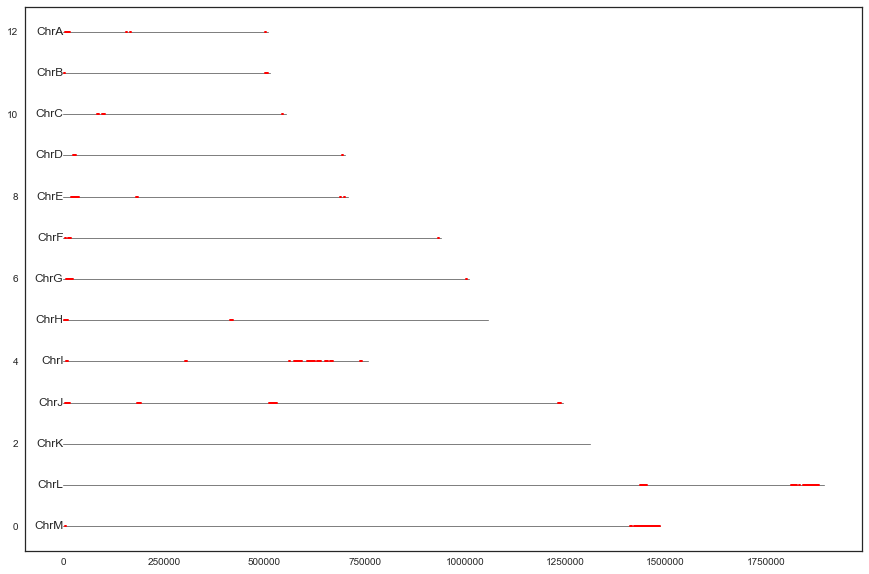

In [50]:
# Draw PCR non-unqiue regions
plot_x = []
plot_y = []
for c, loc in non_pcr_loc.items():
    chid = ord(c[-1]) - 65
    chid = 12 - chid
    plt.plot((0, len(bg2_genome[c])), (chid, chid), color='grey', lw=1)
    plot_y.extend([chid, chid, None] * len(loc))
    for l in loc:
        plot_x.extend([l[0], l[1], None])
plt.plot(plot_x, plot_y, color='red', lw=2)
for i in range(13):
    chrom = 'Chr' + chr(65 + i)
    plt.text(0, 12 - i, chrom, ha='right', va='center')

In [51]:
# save non unique pcr location
with open('bg2.05.pcr.non.unique.location.tab', 'w') as filep:
    chroms = sorted(non_pcr_loc.keys())
    content = []
    for c in chroms:
        for l in non_pcr_loc[c]:
            content.append('{0}\t{1}\t{2}\n'.format(c, l[0], l[1]))
    filep.write(''.join(content))


In [8]:
# get gene locations
bg2_gene = {}
bg2_chrom_gene_loc = {}
with open('./data/bg2.05.02.gff') as filep:
    next(filep)
    for line in filep:
        ent = line.split()
        if not ent:
            continue
        note = ent[8].split(';')
        sname = note[1].split('=')[1].split('/')[0]
        if sname[-1] != 'g':
            continue
        chrom = ent[0]
        start = int(ent[3]) - 1
        end = int(ent[4])
        direct = ent[6]
        bg2_gene[sname] = [chrom, start, end, direct]
        bg2_chrom_gene_loc.setdefault(chrom, [])
        bg2_chrom_gene_loc[chrom].append([start, end, direct, sname])
print('{} genes loaded in BG2'.format(len(bg2_gene)))


5237 genes loaded in BG2


In [19]:
# Test start and stop codon, as well as overlapping genes
start_codon = 'ATG'
stop_codon = ['TAG', 'TGA', 'TAA']
overlap_gene = []
adjacent_gene = []
small_gene = []
for c, s in bg2_genome.items():
    s = s.upper()
    gloc = bg2_chrom_gene_loc[c]
    gloc.sort(key=lambda x: (x[0], -x[1]))
    for l in gloc:
        if l[1] - l[0] < min_pcr:
            small_gene.append(l[-1])
        if l[2] == '+':
            if s[l[0]: l[0] + 3] != start_codon:
                print('{}: starts with {}'.format(l[-1], s[l[0]: l[0] + 3]))
            if s[l[1] - 3: l[1]] not in stop_codon:
                print('{}: ends with {}'.format(l[-1], s[l[1] - 3: l[1]]))      
        else:
            cstart = rc_seq(s[l[1] - 3: l[1]])
            cend = rc_seq(s[l[0]: l[0] + 3])
            if cstart != start_codon:
                print('{}: starts with {}'.format(l[-1], cstart))
            if cend not in stop_codon:
                print('{} ends with {}'.format(l[-1], cend))
    cur_l = gloc[0]
    for l in gloc[1:]:
        if cur_l[1] > l[0]:
            print('Overlapping {}:{}:{}-{} and {}:{}:{}-{}'.format(
                cur_l[-1], c, cur_l[0], cur_l[1],
                l[-1], c, l[0], l[1]
            ))
            overlap_gene.append(cur_l[-1])
            overlap_gene.append(l[-1])
        cur_l = l
    cur_l = gloc[0]
    for l in gloc[1:]:
        if l[0] - min_pcr < cur_l[1] < l[0]:
            adjacent_gene.append(cur_l[-1])
            adjacent_gene.append(l[-1])
        cur_l = l
overlap_gene = sorted(list(set(overlap_gene)))
adjacent_gene = sorted(list(set(adjacent_gene)))
small_gene.sort()
print("{} genes with adjacent distance < {} bp".format(len(adjacent_gene), min_pcr))
print('{} genes with gene length < {} bp'.format(len(small_gene), min_pcr))

Overlapping CAGL0B00220g:ChrB:13089-13320 and CAGL0B00242g:ChrB:13286-13841
Overlapping CAGL0B02761g:ChrB:268319-270056 and CAGL0B02772g:ChrB:270037-271336
CAGL0G09119g: starts with GGT
Overlapping CAGL0G09218g:ChrG:893650-894790 and CAGL0G09229g:ChrG:894786-895122
Overlapping CAGL0I06710g:ChrI:248394-250410 and CAGL0I06721g:ChrI:250378-250651
Overlapping CAGL0M02002g:ChrM:252513-253638 and CAGL0M02013g:ChrM:253614-254268
Overlapping CAGL0M09636g:ChrM:965124-965874 and CAGL0M09647g:ChrM:965870-967436
1984 genes with adjacent distance < 300 bp
190 genes with gene length < 300 bp


In [20]:
overlap_gene

['CAGL0B00220g',
 'CAGL0B00242g',
 'CAGL0B02761g',
 'CAGL0B02772g',
 'CAGL0G09218g',
 'CAGL0G09229g',
 'CAGL0I06710g',
 'CAGL0I06721g',
 'CAGL0M02002g',
 'CAGL0M02013g',
 'CAGL0M09636g',
 'CAGL0M09647g']

In [23]:
# Parameters for deletion primers
# off-targetting were simply predicted by the terminal kmer in the primer pair
from sequence_lib import calc_tm
tm = 55.
tm_tolerance = 2.
min_primer_len = 18
max_primer_len = 35
min_reg_primer_len = 18
max_reg_primer_len = 35
max_outside = 150
min_outside = 50
step_success = 100
max_pcr = 500
min_pcr = 300
pcr_th = 1000
ksize = 10
max_total_hit = 10
left_overhang = "cacggcgcgcctagcagcgg"
right_overhang = 'cgacggtgtcggtctcgtag'
info = ("Paratmeters for Deletion Primers\n"
        "Min_PCR length for overlap: {}\n"
        "Max PCR length for overlap: {}\n"
        "Min_Primer length {}\n"
        "Max_Primer length {}\n"
        "Tm: {} C\n"
        "Tm_tolerance: {}\n"
        "Left overhang: {}\n"
        "Right overhang: {}\n"
        "kmer for test: {}\n"
        "max kmer hit: {}\n").format(
    min_pcr, max_pcr, min_primer_len, max_primer_len,
    tm, tm_tolerance,left_overhang, right_overhang, ksize, max_total_hit
)
print(info)

Paratmeters for Deletion Primers
Min_PCR length for overlap: 300
Max PCR length for overlap: 500
Min_Primer length 18
Max_Primer length 35
Tm: 55.0 C
Tm_tolerance: 2.0
Left overhang: cacggcgcgcctagcagcgg
Right overhang: cgacggtgtcggtctcgtag
kmer for test: 10
max kmer hit: 10



In [96]:
class PcrPrimerPair(object):
    def __init__(self, forward_seq="", reverse_seq=""):
        self.forward_name = ""
        self.reverse_name = ""
        self._forward_seq = forward_seq
        self._reverse_seq = reverse_seq
        self.forward_tm = 0.
        self.reverse_tm = 0.
        self.forward_gc = 0.
        self.reverse_gc = 0.
        self.product_length = 0.
        self.potential_off_length = 0.
        self.forward_location = ""
        self.reverse_location = ""
        self.product_sequence = ""
        
    def print_table(self):
        fcontent = '\t'.join(map(str, 
            [self.forward_name, self._forward_seq, self.forward_tm, self.forward_gc,
             self.product_length, self.potential_off_length, self.forward_location, self.product_sequence]))
        rcontent = '\t'.join(map(str, 
            [self.reverse_name, self._reverse_seq, self.reverse_tm, self.reverse_gc,
             self.product_length, self.potential_off_length, self.reverse_location, self.product_sequence]))
        return "{}\n{}\n".format(fcontent, rcontent)
    
    @property
    def forward_seq(self):
        return self._forward_seq
    
    @forward_seq.setter
    def forward_seq(self, seq):
        self._forward_seq = seq
        if len(seq) > 0:
            self.forward_gc = PcrPrimerPair.calc_gc(seq)
            self.forward_tm = PcrPrimerPair.calc_tm(seq)
            
    @property
    def reverse_seq(self):
        return self._reverse_seq
    
    @reverse_seq.setter
    def reverse_seq(self, seq):
        self._reverse_seq = seq
        if len(seq) > 0:
            self.reverse_gc = PcrPrimerPair.calc_gc(seq)
            self.reverse_tm = PcrPrimerPair.calc_tm(seq)
            
    @staticmethod
    def calc_gc(seq):
        s = seq.upper()
        if len(s) == 0:
            return 0
        gc_count = s.count('G') + s.count('C')
        return gc_count / len(s)
    
    @staticmethod
    def calc_tm(seq):
        """Calculate the Tm for primers.
    
        primer: 50 nM ; Na+: 50 mM, pH = 7
        """
        seq = seq.upper()
        length = len(seq)
        try:
            assert len(seq) > 1
        except AssertionError:
            print("The sequence: %s is too short to calculate Tm" % seq)
        gc_count = seq.count("G") + seq.count("C")
        if length <= 13:
            return (length - gc_count) * 2 + gc_count *4
        else:
            return 64.9 + 41 * (gc_count - 16.4) / length      
        
    @staticmethod
    def print_header():
        return "Name\tPrimerSeq\tTm\tGC\tProductLength\tOff-targetLength\tLocation\tProductSequence\n"
    
    @staticmethod
    def rc_seq(seq):
        """Returns the reverse compliment sequence."""
        rc_nt_ls = []
        rc_dict = {
            "a": "t",
            "c": "g",
            "t": "a",
            "g": "c",
            "n": "n",
            "A": "T",
            "C": "G",
            "T": "A",
            "G": "C",
            "N": "N"
        }
        rc_nt_ls = [rc_dict[seq[i]] for i in range(len(seq)-1, -1, -1)]
        rc_seq_ = "".join(rc_nt_ls)
        return rc_seq_        


class PcrPrimerOverhang(PcrPrimerPair):
    left_overhang = "cacggcgcgcctagcagcgg"
    right_overhang = 'cgacggtgtcggtctcgtag'
    
    def __init__(self, forward_seq="", reverse_seq=""):
        super().__init__(forward_seq, reverse_seq)
        self._forward_seq_overhang = left_overhang + forward_seq
        self._reverse_seq_overhang = right_overhang + reverse_seq
    
    @property
    def forward_seq(self):
        return self._forward_seq
    
    @forward_seq.setter
    def forward_seq(self, seq):
        self._forward_seq = seq
        self._forward_seq_overhang = left_overhang + seq
        if len(seq) > 0:
            self.forward_gc = PcrPrimerPair.calc_gc(seq)
            self.forward_tm = PcrPrimerPair.calc_tm(seq)
            
    @property
    def reverse_seq(self):
        return self._reverse_seq
    
    @reverse_seq.setter
    def reverse_seq(self, seq):
        self._reverse_seq = seq
        self._reverse_seq_overhang = right_overhang + seq
        if len(seq) > 0:
            self.reverse_gc = PcrPrimerPair.calc_gc(seq)
            self.reverse_tm = PcrPrimerPair.calc_tm(seq)
        
        
    def print_header():
        return "Name\tPrimer_with_Overhang\tPrimerSeq\tTm\tGC\tProductLength\tOff-targetLength\tLocation\tProductSequence\n"
 
    def print_table(self):
        fcontent = '\t'.join(map(str, 
            [self.forward_name, self._forward_seq, self.forward_tm, self.forward_gc,
             self.product_length, self.potential_off_length, self.forward_location, self.product_sequence]))
        rcontent = '\t'.join(map(str, 
            [self.reverse_name, self._reverse_seq, self.reverse_tm, self.reverse_gc,
             self.product_length, self.potential_off_length, self.reverse_location, self.product_sequence]))
        return "{}\n{}\n".format(fcontent, rcontent)
    

In [25]:

# search primers with homology ends
homo_primers = {}
no_w_primer = []
no_c_primer = []
for gene, loc in bg2_gene.items():
    chrom, start, end, direct = loc
    for l in range(min_primer_len, max_primer_len + 1):
        wprimer = bg2_genome[chrom][start - l: start]
        w_tm = calc_tm(wprimer)
        if abs(w_tm - tm) < tm_tolerance:
            homo_primers[gene] = [[wprimer, tm], []]
            break
    else:
        no_w_primer.append(gene)
    for l in range(min_primer_len, max_primer_len + 1):
        cprimer = bg2_genome[chrom][end: end + l]
        c_tm = calc_tm(cprimer)
        if abs(c_tm - tm) < tm_tolerance:
            homo_primers.setdefault(gene, [[], []])
            homo_primers[gene][1] = [cprimer, tm]
            break
    else:
        no_c_primer.append(gene)
print('{} genes had no W strand homology primer'.format(len(no_w_primer)))
print('{} genes had no c strand homology primer'.format(len(no_c_primer)))
good_gene_count = 0
for p in homo_primers.values():
    if p[0] and p[1]:
        good_gene_count += 1
print('{} genes had both w and c strand homology primer'.format(good_gene_count))

289 genes had no W strand homology primer
297 genes had no c strand homology primer
4664 genes had both w and c strand homology primer


We cannot find one good Tm for all the genes, look for Tm 50 C- 60 C specifically



In [26]:
tm_ls = [55, 54, 56, 53, 57, 52, 58, 51, 59, 50, 60]
tm_count = {t: 0 for t in tm_ls}
homo_primers = {}
for t in tm_ls:
    for gene, loc in bg2_gene.items():
        if gene in homo_primers and homo_primers[gene][0] and homo_primers[gene][1]:
            continue
        chrom, start, end, direct = loc
        for l in range(min_primer_len, max_primer_len + 1):
            wprimer = bg2_genome[chrom][start - l: start]
            w_tm = calc_tm(wprimer)
            if abs(w_tm - t) < tm_tolerance:
                homo_primers[gene] = [[wprimer, w_tm], [], 0]
                break
        for l in range(min_primer_len, max_primer_len + 1):
            cprimer = bg2_genome[chrom][end: end + l]
            c_tm = calc_tm(cprimer)
            if abs(c_tm - t) < tm_tolerance:
                homo_primers.setdefault(gene, [[], [], 0])
                homo_primers[gene][1] = [cprimer, c_tm]
                if homo_primers[gene][0] and homo_primers[gene][1]:
                    homo_primers[gene][2] = t
                    tm_count[t] += 1
                break
no_single_tm_homo_primer_gene = {}
for g in bg2_gene:
    if g not in homo_primers or not (homo_primers[g][0] and homo_primers[g][1]):
        chrom, start, end, direct = bg2_gene[g]
        no_single_tm_homo_primer_gene[g] = [bg2_genome[chrom][start - max_primer_len: start], 
                                  bg2_genome[chrom][end: end + max_primer_len]]
print(tm_count)
print('{} genes had no homo primer with same Tm from 50 C to 60 C'.format(len(no_single_tm_homo_primer_gene)))


{55: 4664, 54: 292, 56: 13, 53: 161, 57: 0, 52: 70, 58: 7, 51: 24, 59: 0, 50: 3, 60: 1}
2 genes had no homo primer with same Tm from 50 C to 60 C


0 genes had no valid homo left primer

0 genes had no valid homo right primer

0 genes had no valid homo primer at all

{55: 6481, 54: 2340, 56: 496, 53: 571, 57: 14, 52: 301, 58: 0, 51: 163, 59: 7, 50: 70, 60: 0, 49: 24, 61: 2, 48: 3, 62: 0, 47: 0, 63: 2}


([<matplotlib.axis.XTick at 0x7efcbf2fe908>,
 <a list of 17 Text xticklabel objects>)

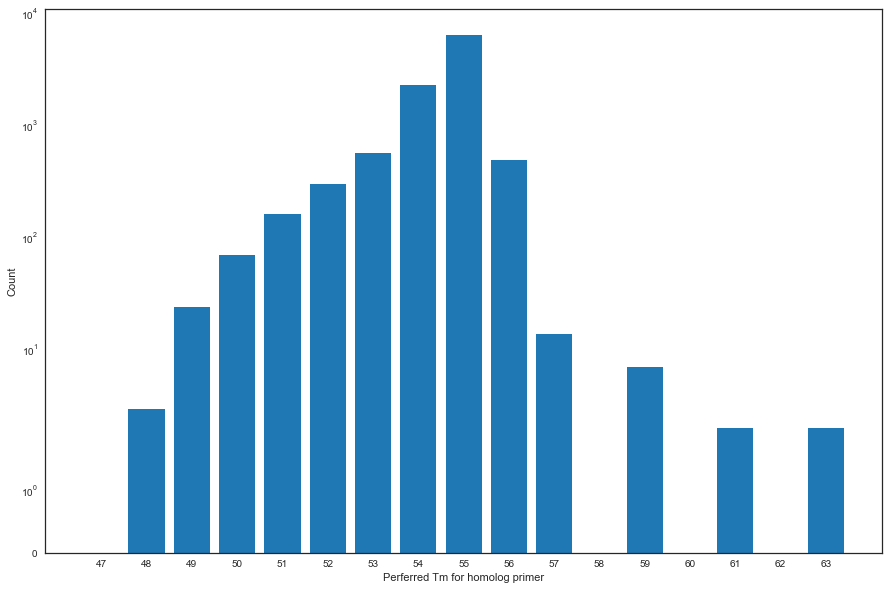

In [171]:
# Look for deletion primer pair with no single tm restriction
# Tm for out-test primer was fixed to tm
# Tm for deletion primer varied according to tm_ls
# Tm for inner primer varied according to tm_ls
# First test for homo primer
inner_step = 20 # substract 20 bp from N-terminal to look for inner primers
tm_ls = [55, 54, 56, 53, 57, 52, 58, 51, 59, 50, 60, 49, 61, 48, 62, 47, 63]
gene_deletion_primer = {}
no_left_homo = []
no_right_homo = []
no_both_homo = []
tm_count = {t: 0 for t in tm_ls}
homo_primer_length = {}
for c, loc in bg2_chrom_gene_loc.items():
    seq = bg2_genome[c]
    loc.sort()

    for i, l in enumerate(loc):
        if i == 0:
            left_flank_size = l[0] - 1
            right_flank_size = loc[1][0] - l[1]
        elif i == len(loc) - 1:
            left_flank_size = l[0] - loc[i-1][1]
            right_flank_size = len(s) - l[1]
        else:
            left_flank_size = l[0] - loc[i-1][1]
            right_flank_size = loc[i + 1][0] - l[1]

        start, end, direct, sname = l
        homo_primer_length[sname] = [[0, 0], [0, 0]]        
        # Wason flanking primer        
        homo_primer = [seq[start - l: start] 
                       for l in range(min_primer_len, max_primer_len + 1)]
        tm_homo = [int(calc_tm(p)) for p in homo_primer]
        valid_tm = [t for t in tm_ls if t in tm_homo]
        if not valid_tm:                
            no_left_homo.append(sname)
        else:
            tm_count[valid_tm[0]] += 1
            homo_primer_length[sname][0] = [
                tm_homo.index(valid_tm[0]) + min_primer_len, valid_tm[0]]
        # Crick flanking primer        
        homo_primer = [seq[end: end + l] 
                       for l in range(min_primer_len, max_primer_len + 1)]
        tm_homo = [int(calc_tm(p)) for p in homo_primer]
        valid_tm = [t for t in tm_ls if t in tm_homo]
        if not valid_tm:                
            no_right_homo.append(sname)
            if no_left_homo and sname == no_left_homo[-1]:
                no_both_homo.append(sname)
        else:
            tm_count[valid_tm[0]] += 1
            homo_primer_length[sname][1] = [
                tm_homo.index(valid_tm[0]) + min_primer_len, valid_tm[0]]            
        
print('{} genes had no valid homo left primer\n'.format(len(no_left_homo)))
print('{} genes had no valid homo right primer\n'.format(len(no_right_homo)))
print('{} genes had no valid homo primer at all\n'.format(len(no_both_homo)))            
print(tm_count)
plt.bar(tm_count.keys(), tm_count.values())
plt.xlabel('Perferred Tm for homolog primer')
plt.ylabel('Count')
plt.yscale('symlog')
plt.xticks(list(tm_count.keys()))

In [146]:
# primer length distribution

30

In [27]:
x_homo_primer_length = []
y_homo_primer_tm = []
for p in homo_primer_length.values():
    x_homo_primer_length.extend([p[0][0], p[1][0]])
    y_homo_primer_tm.extend([p[0][1], p[1][1]])
plt.scatter(x_homo_primer_length, y_homo_primer_tm, s=4, color='blue')
plt.xlabel('Homo Primer length')
plt.ylabel('Tm')

NameError: name 'homo_primer_length' is not defined

/home/zhuwei/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 0, 'Length of homo primer')

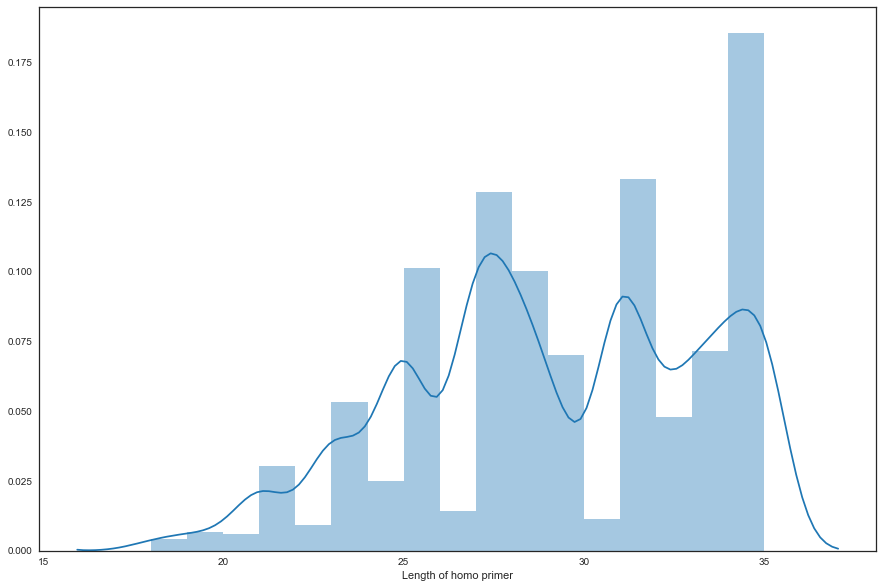

In [165]:
sns.distplot(x_homo_primer_length, bins=np.arange(min_primer_len, max_primer_len + 1))
plt.xlabel('Length of homo primer')

In [17]:
# Generate deletion primer pair
inner_step = 20 # substract 20 bp from N-terminal to look for inner primers
tm_ls = [55, 54, 56, 53, 57, 52, 58, 51, 59, 50, 60, 49, 61, 48, 62, 47, 63]
gene_deletion_primer = {}
no_left_flank = []
no_right_flank = []
no_both_flank = []
tm_count = {t: 0 for t in tm_ls}

for c, loc in bg2_chrom_gene_loc.items():
    seq = bg2_genome[c]
    seq = seq.upper()
    loc.sort()

    for i, l in enumerate(loc):
        if i == 0:
            left_flank_size = l[0] - 1
            right_flank_size = loc[1][0] - l[1]
        elif i == len(loc) - 1:
            left_flank_size = l[0] - loc[i-1][1]
            right_flank_size = len(s) - l[1]
        else:
            left_flank_size = l[0] - loc[i-1][1]
            right_flank_size = loc[i + 1][0] - l[1]

        start, end, direct, sname = l       
        # Wason flanking primer
        # homo primer
        homo_primer = [seq[start - l: start] 
                       for l in range(min_primer_len, max_primer_len + 1)]
        tm_homo = [int(calc_tm(p)) for p in homo_primer]
        valid_tm = [t for t in tm_ls if t in tm_homo]
        vt = valid_tm[0]
        tm_count[vt] += 1
        wprimer = rc_seq(homo_primer[tm_homo.index(vt)])
        wtm = calc_tm(wprimer)
        wloc = start
        if direct == '+':
            homo_wprimer = left_overhang + wprimer.upper()
        else:
            homo_wprimer = right_overhang + wprimer.upper()

        # flank primer

        f_wloc = -1
        f_wtm = -1
        f_wprimer = ''
        for l_primer in range(min_reg_primer_len, max_reg_primer_len + 1):
            p = start - max_pcr + max_primer_len            
            while p < start - min_pcr:
                kmer = rc_seq(seq[p - ksize: p])
                if kmer not in r_kmer_location:
                    p += 1
                    continue
                tmp_primer = seq[p - l_primer: p]
                tmp_tm = calc_tm(tmp_primer)
                if abs(tmp_tm - wtm) < tm_tolerance:
                    f_wprimer = tmp_primer
                    f_wtm = tmp_tm
                    f_wloc = p - l_primer + 1
                    p = start
                    break
                else:
                    p += 1
            if f_wprimer:
                break
               
        if f_wprimer:
            gene_deletion_primer[sname] = [
                [[wprimer, wtm, wloc], [f_wprimer, f_wtm, f_wloc], []], [[], [], []]]
            # Look for validate primer
            for l_primer in range(min_reg_primer_len, max_reg_primer_len + 1):
                p = f_wloc - max_outside + max_reg_primer_len
                while p < f_wloc - min_reg_primer_len:
                    kmer = rc_seq(seq[p - ksize: p])
                    
                    
                
        else:
            no_left_flank.append(sname)
            gene_deletion_primer[sname] = [
                [[wprimer, wtm, wloc], [], []], [[], [], []]]            
                
        # Crick flanking primer        
        homo_primer = [seq[end: end + l] 
                       for l in range(min_primer_len, max_primer_len + 1)]
        tm_homo = [int(calc_tm(p)) for p in homo_primer]
        valid_tm = [t for t in tm_ls if t in tm_homo]
        vt = valid_tm[0]
        tm_count[vt] += 1
        cprimer = homo_primer[tm_homo.index(vt)]
        ctm = calc_tm(cprimer)
        cloc = start
        if direct == '-':
            homo_cprimer = left_overhang + cprimer.upper()
        else:
            homo_cprimer = right_overhang + cprimer.upper()
        # flank primer
        p = end + max_pcr - max_primer_len
        r_cloc = -1
        r_ctm = -1
        r_cprimer = ''
        for l_primer in range(min_reg_primer_len, max_reg_primer_len + 1):
            p = end + max_pcr - max_primer_len
            while p > end + min_pcr:
                kmer = seq[p: p + ksize]
                kmer = rc_seq(kmer)
                if kmer not in r_kmer_location:
                    p -= 1
                    continue
            # Primer extension
                tmp_primer = seq[p: p + l_primer]
                tmp_tm = calc_tm(tmp_primer)
                if abs(tmp_tm - ctm) < tm_tolerance:
                    r_cprimer = rc_seq(tmp_primer)
                    r_ctm = tmp_tm
                    r_cloc = p + l_primer
                    p = end
                    break
                else:
                    p -= 1
            else:
                p -= 1
            if r_cprimer:
                break
        if r_cprimer:
            gene_deletion_primer[sname][1] = [
                [cprimer, ctm, cloc], [r_cprimer, r_ctm, r_cloc]]
            # Look for validate primer
            
        else:
            no_right_flank.append(sname)
            gene_deletion_primer[sname][1] = [
                [cprimer, ctm, cloc], []]
        # break
print('{} genes had no left flank primer'.format(len(no_left_flank)))
print('{} genes had no right flank primer'.format(len(no_right_flank)))

2 genes had no left flank primer
2 genes had no right flank primer


In [24]:
print(no_left_flank)
print(no_right_flank)
print(len(left_overhang), len(right_overhang))

['CAGL0H04301g', 'CAGL0H07491g']
['CAGL0E01155g', 'CAGL0G05566g']
20 20


In [34]:
# print length distribution
homo_primer_length = []
homo_primer_gc = []
homo_primer_tm = []
flank_primer_length = []
flank_primer_gc = []
flank_primer_tm = []
deletion_length = []

def calc_gc(seq):
    s = seq.upper()
    if not s:
        return 0
    return (s.count('G') + s.count('C')) / len(s)

for pls in gene_deletion_primer.values():
    wprimer, cprimer = pls
    whprimer, wfprimer = wprimer
    chprimer, cfprimer = cprimer
    if whprimer and wfprimer:
        deletion_length.append(whprimer[2] - wfprimer[2] + 1)
    if chprimer and cfprimer:
        deletion_length.append(cfprimer[2] - chprimer[2] + 1)
    for p in [whprimer, chprimer]:
        if not p:
            continue
        homo_primer_length.append(len(p[0]))
        homo_primer_gc.append(calc_gc(p[0]))
        homo_primer_tm.append(p[1])
    for p in [wfprimer, cfprimer]:
        if not p:
            continue
        flank_primer_length.append(len(p[0]))
        flank_primer_gc.append(calc_gc(p[0]))
        flank_primer_tm.append(p[1])
        if p[1] < min_reg_primer_len:
            print(pls)
print(max(deletion_length))

23779


/home/zhuwei/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


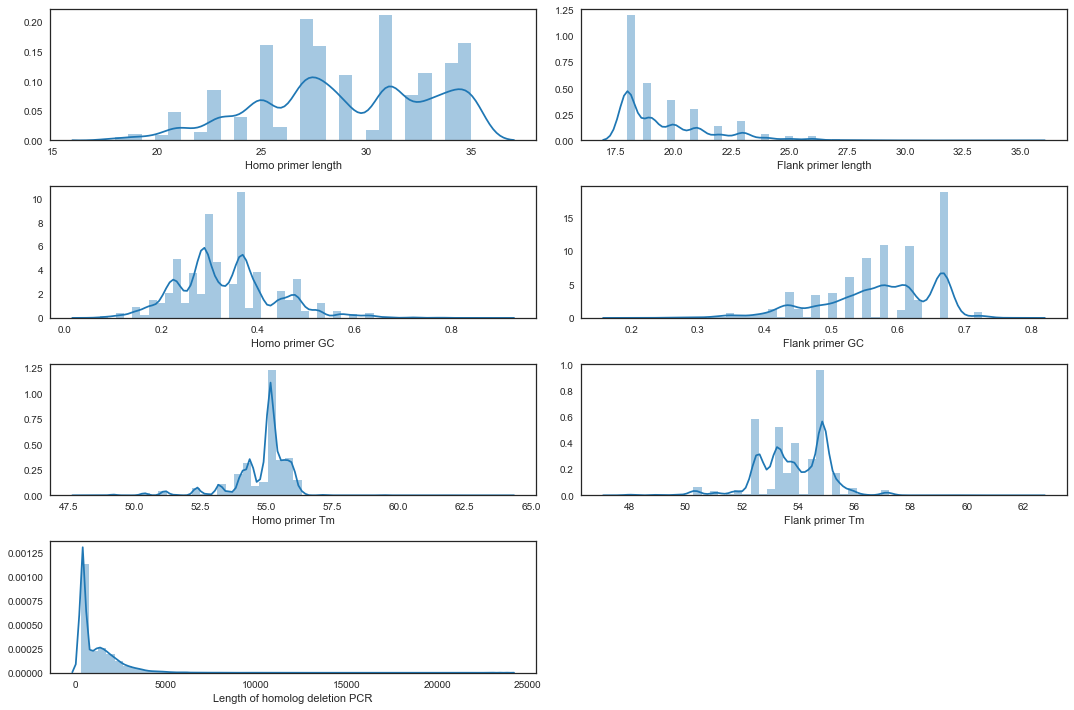

In [32]:
ax = plt.subplot(421)
sns.distplot(homo_primer_length, ax=ax)
plt.xlabel('Homo primer length')
ax = plt.subplot(423)
sns.distplot(homo_primer_gc, ax=ax)
plt.xlabel('Homo primer GC')
ax = plt.subplot(425)
sns.distplot(homo_primer_tm, ax=ax)
plt.xlabel('Homo primer Tm')
ax = plt.subplot(422)
sns.distplot(flank_primer_length, ax=ax)
plt.xlabel('Flank primer length')
ax = plt.subplot(424)
sns.distplot(flank_primer_gc, ax=ax)
plt.xlabel('Flank primer GC')
ax = plt.subplot(426)
sns.distplot(flank_primer_tm, ax=ax)
plt.xlabel('Flank primer Tm')
ax = plt.subplot(427)
sns.distplot(deletion_length, ax=ax)
plt.xlabel('Length of homolog deletion PCR')
plt.tight_layout()